<a href="https://colab.research.google.com/github/RMoulla/SSL26/blob/main/Copie_de_TP_Explicabilit%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TP : Explicabilité des modèles de deep learning pour les images avec LIME et SHAP**

## **Objectif**
Ce TP vise à explorer comment interpréter les prédictions d’un modèle de deep learning appliqué aux images à l’aide de **LIME** et **SHAP**. Ces outils permettent d’identifier les parties de l’image qui influencent le plus les décisions du modèle, contribuant ainsi à rendre les modèles plus transparents et compréhensibles.

---

## **Contexte**
Les modèles de deep learning, bien qu’efficaces, sont souvent considérés comme des boîtes noires. Comprendre pourquoi un modèle fait une certaine prédiction est essentiel pour :  
1. Identifier les biais potentiels dans le modèle.  
2. Valider la fiabilité des prédictions dans des applications sensibles.  
3. Construire la confiance des utilisateurs finaux.

Dans ce TP, nous allons :  
1. Charger un modèle de classification d’images pré-entraîné avec PyTorch.  
2. Utiliser ce modèle pour prédire les classes d’images fournies.  
3. Appliquer **LIME** et **SHAP** pour expliquer ces prédictions.  
4. Comparer les visualisations générées par ces deux outils et analyser les résultats.

---

## **Plan du TP**

### **Étape 1 : Préparation de l’environnement**
1. Installer les bibliothèques nécessaires pour PyTorch, LIME, et SHAP.  
2. Télécharger ou préparer un ensemble d’images pour les tests (votre dataset préféré, des images issues d’ImageNet, etc.).

---

### **Étape 2 : Charger un modèle pré-entraîné**
1. Nous allons utiliser un modèle pré-entraîné disponible dans PyTorch, comme ResNet18 ou VGG16, avec des poids pré-entraînés sur ImageNet.  
2. Le modèle sera utilisé pour effectuer des prédictions sur les images, après les avoir redimensionnées et normalisées en fonction des besoins du modèle.  
3. Pour chaque image, nous afficherons les classes prédites avec leurs scores de confiance.

---

### **Étape 3 : Explicabilité avec LIME**
1. **Présentation de LIME :**  
   LIME fonctionne en créant des perturbations localisées sur une image (par exemple, en masquant des zones spécifiques) pour mesurer l’impact de chaque zone sur la prédiction.  
2. **Étapes :**  
   - Segmenter l’image en pixels ou en superpixels.  
   - Identifier les zones les plus influentes pour une prédiction donnée.  
   - Générer une heatmap mettant en évidence les zones importantes pour la classe prédite.  
3. Nous analyserons les résultats pour comprendre quelles parties de l’image influencent le plus la prédiction.

---

### **Étape 4 : Explicabilité avec SHAP**
1. **Présentation de SHAP :**  
   SHAP utilise la théorie des jeux pour attribuer une importance à chaque pixel ou groupe de pixels, en mesurant leur contribution à la prédiction.  
2. **Étapes :**  
   - Fournir les images prétraitées au modèle pour calculer les valeurs SHAP.  
   - Générer une visualisation qui montre les contributions positives et négatives des pixels ou des superpixels pour la prédiction.  
3. Nous interpréterons les visualisations en observant les zones qui favorisent ou défavorisent la classe prédite.

---

### **Étape 5 : Comparaison et analyse des résultats**
1. **Comparaison des visualisations :**  
   - Identifier les différences et similitudes entre les résultats de LIME et SHAP.  
   - Analyser les zones mises en évidence par chaque méthode.  
2. **Discussion :**  
   - Quels sont les points forts et limites de chaque méthode ?  
   - Les deux approches donnent-elles des explications cohérentes ?  
   - Quels défis rencontrons-nous en utilisant ces outils avec des modèles de grande taille ou des images complexes ?

---

## **Livrables attendus**
1. Les heatmaps générées par LIME et SHAP pour au moins deux images.  
2. Une analyse comparative des résultats obtenus avec LIME et SHAP.  
---

## Étape 1 : Préparation de l'environnement

In [17]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")


Using device: mps


## Étape 2 : Charger un modèle pré-entraîné (ResNet18)

In [18]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model = model.to(device)
model.eval()

IMAGENET_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = requests.get(IMAGENET_URL).text.strip().split("\n")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print(f"Model loaded: ResNet18 with {len(imagenet_classes)} ImageNet classes")


Model loaded: ResNet18 with 1000 ImageNet classes


## Charger des images de test

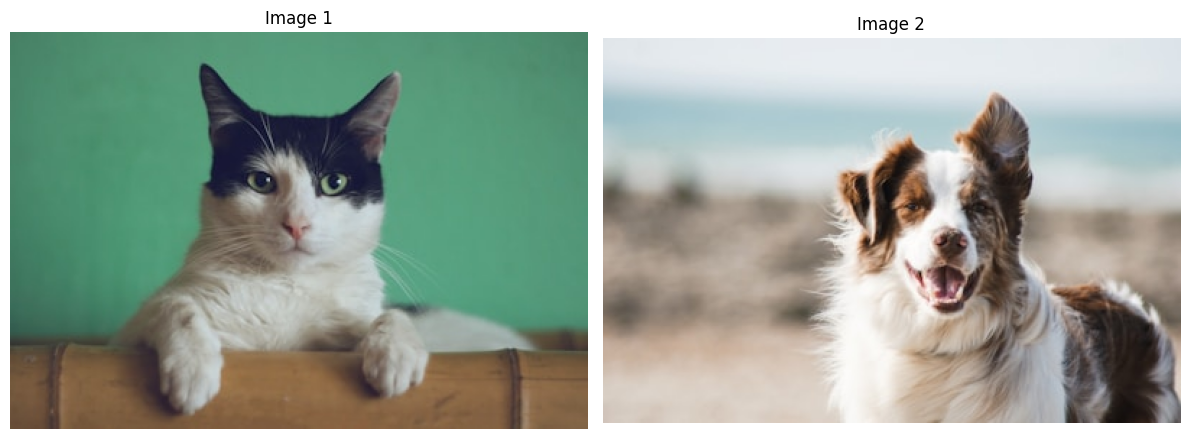

In [19]:
image_urls = [
    "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=400",
    "https://images.unsplash.com/photo-1587300003388-59208cc962cb?w=400",
]

headers = {"User-Agent": "Mozilla/5.0"}

images = []
for url in image_urls:
    response = requests.get(url, headers=headers)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    images.append(img)

fig, axes = plt.subplots(1, len(images), figsize=(12, 5))
for i, img in enumerate(images):
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Image {i+1}")
plt.tight_layout()
plt.show()


## Prédictions du modèle

In [20]:
def predict(img):
    input_tensor = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top5_prob, top5_idx = torch.topk(probabilities, 5)
    return [(imagenet_classes[idx], prob.item()) for idx, prob in zip(top5_idx, top5_prob)]

for i, img in enumerate(images):
    print(f"\n=== Image {i+1} - Top 5 prédictions ===")
    predictions = predict(img)
    for class_name, prob in predictions:
        print(f"  {class_name}: {prob*100:.2f}%")



=== Image 1 - Top 5 prédictions ===
  Egyptian cat: 59.89%
  tabby: 8.11%
  plastic bag: 6.55%
  tiger cat: 5.16%
  Siamese cat: 2.51%

=== Image 2 - Top 5 prédictions ===
  Border collie: 61.17%
  collie: 19.72%
  Brittany spaniel: 7.80%
  papillon: 2.64%
  Saint Bernard: 2.12%


## Étape 3 : Explicabilité avec LIME

In [21]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def batch_predict_lime(images_array):
    batch = torch.stack([preprocess(Image.fromarray(img)) for img in images_array])
    batch = batch.to(device)
    with torch.no_grad():
        outputs = model(batch)
    probs = torch.nn.functional.softmax(outputs, dim=1)
    return probs.cpu().numpy()

explainer = lime_image.LimeImageExplainer()

lime_results = []
for i, img in enumerate(images):
    print(f"Generating LIME explanation for image {i+1}...")
    img_array = np.array(img)
    explanation = explainer.explain_instance(
        img_array,
        batch_predict_lime,
        top_labels=5,
        hide_color=0,
        num_samples=1000
    )
    lime_results.append(explanation)
    print(f"  Done!")


Generating LIME explanation for image 1...


100%|██████████| 1000/1000 [00:05<00:00, 182.95it/s]


  Done!
Generating LIME explanation for image 2...


100%|██████████| 1000/1000 [00:05<00:00, 179.66it/s]

  Done!


## Visualisation LIME

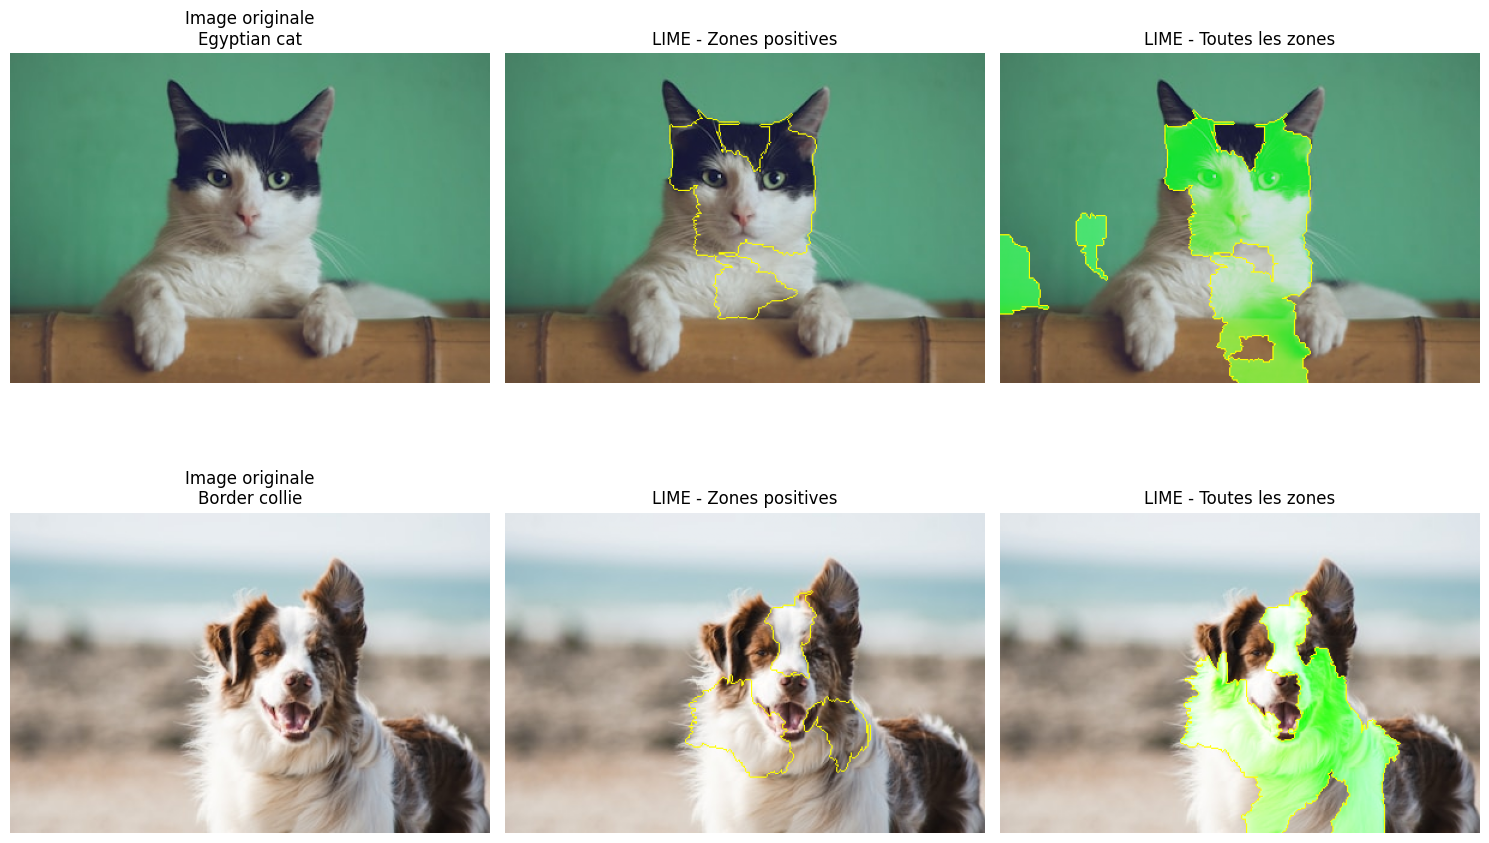

In [22]:
fig, axes = plt.subplots(len(images), 3, figsize=(15, 5*len(images)))

for i, (img, explanation) in enumerate(zip(images, lime_results)):
    top_label = explanation.top_labels[0]
    
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Image originale\n{imagenet_classes[top_label]}")
    axes[i, 0].axis("off")
    
    temp, mask = explanation.get_image_and_mask(
        top_label, positive_only=True, num_features=5, hide_rest=False
    )
    axes[i, 1].imshow(mark_boundaries(temp/255.0, mask))
    axes[i, 1].set_title("LIME - Zones positives")
    axes[i, 1].axis("off")
    
    temp, mask = explanation.get_image_and_mask(
        top_label, positive_only=False, num_features=10, hide_rest=False
    )
    axes[i, 2].imshow(mark_boundaries(temp/255.0, mask))
    axes[i, 2].set_title("LIME - Toutes les zones")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


## Étape 4 : Explicabilité avec SHAP

In [24]:
import shap

def model_predict_shap(x):
    x = torch.tensor(x).permute(0, 3, 1, 2).float().to(device)
    with torch.no_grad():
        output = model(x)
    return output.cpu().numpy()

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

preprocessed_images = []
for img in images:
    img_resized = img.resize((224, 224))
    img_array = np.array(img_resized) / 255.0
    img_normalized = (img_array - mean) / std
    preprocessed_images.append(img_normalized)

preprocessed_images = np.array(preprocessed_images)

masker = shap.maskers.Image("inpaint_telea", preprocessed_images[0].shape)
explainer_shap = shap.Explainer(model_predict_shap, masker, output_names=imagenet_classes)

print("Generating SHAP explanations (this may take a few minutes)...")
shap_values = explainer_shap(preprocessed_images, max_evals=500, batch_size=50)
print("Done!")


cv2 could not be imported!


ModuleNotFoundError: No module named 'cv2'

## Visualisation SHAP

In [ ]:
shap.image_plot(shap_values)


## Étape 5 : Comparaison LIME vs SHAP

In [ ]:
fig, axes = plt.subplots(len(images), 3, figsize=(15, 5*len(images)))

for i, (img, lime_exp) in enumerate(zip(images, lime_results)):
    top_label = lime_exp.top_labels[0]
    
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Original\n{imagenet_classes[top_label]}")
    axes[i, 0].axis("off")
    
    temp, mask = lime_exp.get_image_and_mask(
        top_label, positive_only=True, num_features=5, hide_rest=False
    )
    axes[i, 1].imshow(mark_boundaries(temp/255.0, mask))
    axes[i, 1].set_title("LIME")
    axes[i, 1].axis("off")
    
    shap_img = shap_values[i].values[:, :, :, top_label]
    shap_img_norm = (shap_img - shap_img.min()) / (shap_img.max() - shap_img.min() + 1e-8)
    axes[i, 2].imshow(np.array(img.resize((224, 224))))
    axes[i, 2].imshow(shap_img_norm.sum(axis=-1), cmap='jet', alpha=0.5)
    axes[i, 2].set_title("SHAP")
    axes[i, 2].axis("off")

plt.suptitle("Comparaison LIME vs SHAP", fontsize=16)
plt.tight_layout()
plt.show()
